In [1]:
import subprocess
import json
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import random
import numpy as np

In [2]:
def create_fio_ini_file(
    ini_filename="fio.ini",
    direct=1, rw="randread", ioengine="io_uring", iodepth=32, size="1g", blocksize=8, 
    hipri=False, fixedbufs=False, registerfiles=True, sqthread_poll=True, numjobs=4,
    thread=True,
):
    ini_file_contents = f"""
[global]
direct={direct}
rw={rw}
ioengine={ioengine}
iodepth={iodepth}
size={size}
blocksize={blocksize}k
numjobs={numjobs}
directory=/mnt/storage_ssd_4tb/fio
group_reporting
{"hipri" if hipri else ""}
{"fixedbufs" if fixedbufs else ""}
{"registerfiles" if registerfiles else ""}
{"sqthread_poll=1" if sqthread_poll else ""}
{"thread" if thread else ""}

[read]
    """
    with open(ini_filename, "w") as ini_file:
        ini_file.write(ini_file_contents)

In [3]:
def run_fio(**kwargs) -> dict[str, object]:
    create_fio_ini_file(**kwargs)

    # Run fio
    p = subprocess.run(["fio", "fio.ini", "--output=fio_output.json", "--output-format=json"], capture_output=True)
    if p.returncode != 0:
        print(p.stderr)
        exit(p.returncode)

    # Load fio_output.json
    with open("fio_output.json", "r") as fh:
        fio_output = json.load(fh)

    # Get results for the "read" job:
    read_job = [job for job in fio_output['jobs'] if job['jobname'] == 'read'][0]['read']

    return {
        "gigabytes_per_sec": read_job["bw_bytes"] / 1E9,
        "iops": read_job["iops"],
    }

In [4]:
def fio_grid_search(nrepeats=1, randomise=False, **kwargs) -> pd.DataFrame:
    """Run `fio` on every combination of specified `fio` parameters.

    For example, the following will run `fio` 4 times in total:
    
        fio_grid_search(iodepth=[32, 64], sqthread_poll=[True, False])

    It will run `fio` with these arguments:

        run_fio(iodepth=32, sqthread_poll=True)
        run_fio(iodepth=32, sqthread_poll=False)
        run_fio(iodepth=64, sqthread_poll=True)
        run_fio(iodepth=64, sqthread_poll=False)
        
    Returns:
        pd.DataFrame with the results. Each row represents a run of `fio`.
    """
    
    # Make sure we get the dict keys and items in the same order.
    # (The ordering of dict.items() and dict.values() isn't guaranteed to be the same).
    items = kwargs.items()
    keys = [item[0] for item in items]
    values = [item[1] for item in items]

    fio_results = []
    product_of_values = list(itertools.product(*values))
    for repeat in range(nrepeats):
        if randomise:
            random.shuffle(product_of_values)

        for i, vals in enumerate(product_of_values):
            fio_kwargs = {k:v for k, v in zip(keys, vals)}
            fio_result = run_fio(**fio_kwargs)
            fio_result.update(fio_kwargs)
            fio_result['repeat'] = repeat
            print(f"\r repeat={repeat+1}/{nrepeats}, i={i+1}/{len(product_of_values)}", end="", flush=True)
            fio_results.append(fio_result)

    return pd.DataFrame(fio_results)

## Grid search over iodepth and numjobs

In [71]:
fio_results = fio_grid_search(
    iodepth=[1, 4, 8, 16, 32, 64, 128, 1024, 4096, 16384],
    numjobs=[1, 2, 4, 8])

{'gigabytes_per_sec': 0.169119833, 'iops': 20644.510947, 'iodepth': 1, 'numjobs': 1}
{'gigabytes_per_sec': 0.336122029, 'iops': 41030.521208, 'iodepth': 1, 'numjobs': 2}
{'gigabytes_per_sec': 0.619049768, 'iops': 75567.598732, 'iodepth': 1, 'numjobs': 4}
{'gigabytes_per_sec': 1.140913081, 'iops': 139271.616417, 'iodepth': 1, 'numjobs': 8}
{'gigabytes_per_sec': 0.572662306, 'iops': 69905.066667, 'iodepth': 4, 'numjobs': 1}
{'gigabytes_per_sec': 1.066807574, 'iops': 130225.534029, 'iodepth': 4, 'numjobs': 2}
{'gigabytes_per_sec': 1.914831607, 'iops': 233744.092733, 'iodepth': 4, 'numjobs': 4}
{'gigabytes_per_sec': 3.078829602, 'iops': 375833.691756, 'iodepth': 4, 'numjobs': 8}
{'gigabytes_per_sec': 1.202398459, 'iops': 146777.155655, 'iodepth': 8, 'numjobs': 1}
{'gigabytes_per_sec': 2.093063984, 'iops': 255500.974659, 'iodepth': 8, 'numjobs': 2}
{'gigabytes_per_sec': 3.251299996, 'iops': 396887.206662, 'iodepth': 8, 'numjobs': 4}
{'gigabytes_per_sec': 4.407354844, 'iops': 538007.183171, 

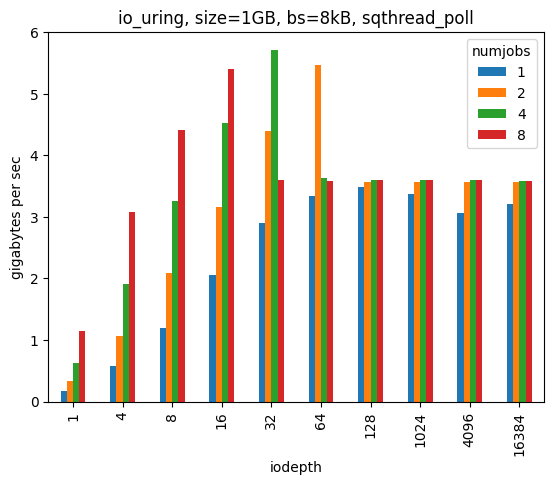

In [73]:
ax = fio_results.pivot_table(values="gigabytes_per_sec", index="iodepth", columns="numjobs").plot.bar()
ax.set_ylabel("gigabytes per sec");
ax.set_title("io_uring, size=1GB, blocksize=8kB, sqthread_poll");

In [75]:
fio_results.to_csv("grid_search_over_iodepth_and_numjobs.csv")

In [76]:
fio_results = fio_grid_search(iodepth=[16, 24, 28, 32, 42, 55, 64], numjobs=[2, 3, 4, 6, 8])

{'gigabytes_per_sec': 3.190911809, 'iops': 389515.601783, 'iodepth': 16, 'numjobs': 2}
{'gigabytes_per_sec': 3.952423892, 'iops': 482473.619632, 'iodepth': 16, 'numjobs': 3}
{'gigabytes_per_sec': 4.521018206, 'iops': 551882.105263, 'iodepth': 16, 'numjobs': 4}
{'gigabytes_per_sec': 5.285029486, 'iops': 645145.200984, 'iodepth': 16, 'numjobs': 6}
{'gigabytes_per_sec': 5.402474586, 'iops': 659481.761006, 'iodepth': 16, 'numjobs': 8}
{'gigabytes_per_sec': 4.067203878, 'iops': 496484.848485, 'iodepth': 24, 'numjobs': 2}
{'gigabytes_per_sec': 4.932963969, 'iops': 602168.453292, 'iodepth': 24, 'numjobs': 3}
{'gigabytes_per_sec': 5.422938505, 'iops': 661979.79798, 'iodepth': 24, 'numjobs': 4}
{'gigabytes_per_sec': 3.617322259, 'iops': 441567.658619, 'iodepth': 24, 'numjobs': 6}
{'gigabytes_per_sec': 3.585114604, 'iops': 437636.0601, 'iodepth': 24, 'numjobs': 8}
{'gigabytes_per_sec': 4.31221616, 'iops': 526393.574297, 'iodepth': 28, 'numjobs': 2}
{'gigabytes_per_sec': 5.096875746, 'iops': 6221

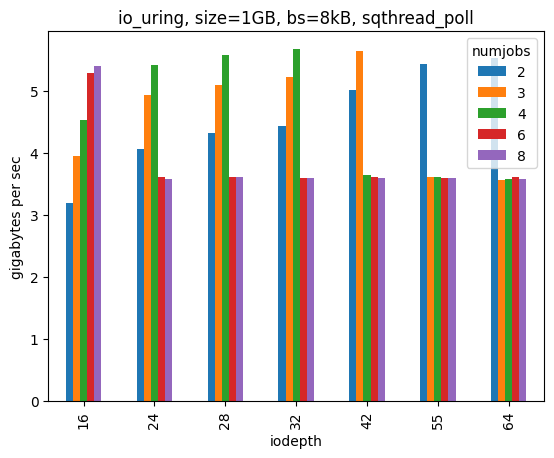

In [78]:
ax = fio_results.pivot_table(values="gigabytes_per_sec", index="iodepth", columns="numjobs").plot.bar()
ax.set_ylabel("gigabytes per sec");
ax.set_title("io_uring, size=1GB, blocksize=8kB, sqthread_poll");

## Vary blocksize

In [102]:
fio_results = fio_grid_search(iodepth=[32], blocksize=[2, 4, 8, 16, 32, 64, 128, 512, 1024, 4096, 16384])

{'gigabytes_per_sec': 1.594271453, 'iops': 778452.858203, 'iodepth': 32, 'blocksize': 2}
{'gigabytes_per_sec': 3.19566019, 'iops': 780190.47619, 'iodepth': 32, 'blocksize': 4}
{'gigabytes_per_sec': 5.520523516, 'iops': 673892.030848, 'iodepth': 32, 'blocksize': 8}
{'gigabytes_per_sec': 5.956958801, 'iops': 363583.911234, 'iodepth': 32, 'blocksize': 16}
{'gigabytes_per_sec': 6.537240937, 'iops': 199500.761035, 'iodepth': 32, 'blocksize': 32}
{'gigabytes_per_sec': 7.006471934, 'iops': 106910.277325, 'iodepth': 32, 'blocksize': 64}
{'gigabytes_per_sec': 7.075728658, 'iops': 53983.525535, 'iodepth': 32, 'blocksize': 128}
{'gigabytes_per_sec': 7.21843243, 'iops': 13768.067227, 'iodepth': 32, 'blocksize': 512}
{'gigabytes_per_sec': 7.206320966, 'iops': 6872.483221, 'iodepth': 32, 'blocksize': 1024}
{'gigabytes_per_sec': 7.146368212, 'iops': 1703.826955, 'iodepth': 32, 'blocksize': 4096}
{'gigabytes_per_sec': 7.158278826, 'iops': 426.666667, 'iodepth': 32, 'blocksize': 16384}


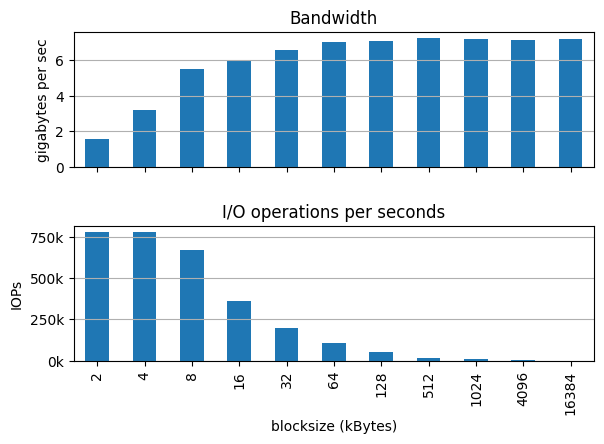

In [142]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

fio_results.set_index("blocksize")["gigabytes_per_sec"].plot.bar(ax=ax1)
ax1.set_ylabel("gigabytes per sec")
ax1.set_xlabel("blocksize (kBytes)")
ax1.grid(axis="y")
ax1.set_title("Bandwidth")

ax2 = fio_results.set_index("blocksize")["iops"].plot.bar(ax=ax2)
ax2.set_ylabel("IOPs")
ax2.set_xlabel("blocksize (kBytes)")
ax2.grid(axis="y")
ax2.set_title("I/O operations per seconds")
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: "{:.0f}k".format(y / 1E3)))

fig.tight_layout(pad=2)

## `io_uring`-specific params

In [ ]:
fio_results = fio_grid_search(
    nrepeats=10,
    randomise=True,
    numjobs=[1, 2, 4],
    hipri=[True, False],
    fixedbufs=[True, False],
    registerfiles=[True, False],
    sqthread_poll=[True, False],
    thread=[True, False],
    iodepth=[8, 32, 128],
    blocksize=[4, 8, 16, 64],
    # rw=["randread", "read"],
)

In [258]:
# fio_results.to_csv("full_fio_results_2.csv")

Text(0.5, 0, 'blocksize (kB)')

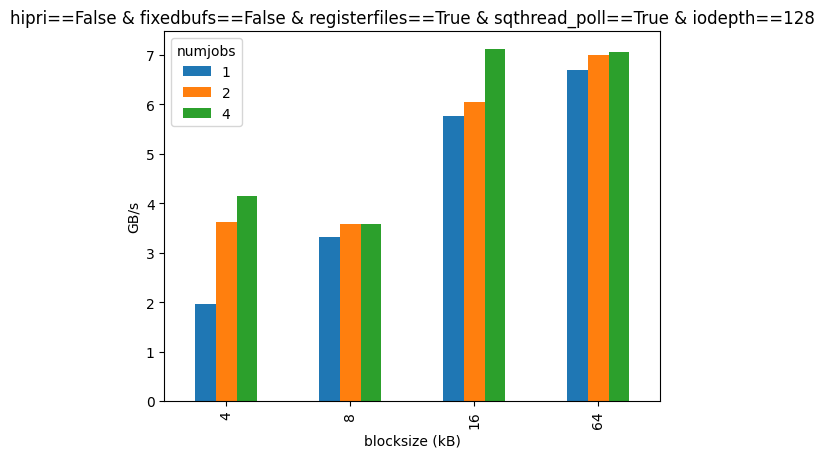

In [312]:
query = "hipri==False & fixedbufs==False & registerfiles==True & sqthread_poll==True & iodepth==128"
ax = (
    fio_results
    .query(query)
    .pivot_table(values="gigabytes_per_sec", index="repeat", columns=["blocksize", "numjobs"])
    .mean()
    .to_frame("gigabytes_per_sec")
    .pivot_table(values="gigabytes_per_sec", index="blocksize", columns=["numjobs"])
    .plot
    .bar()
)
ax.set_title(query)
ax.set_ylabel("GB/s")
ax.set_xlabel("blocksize (kB)")

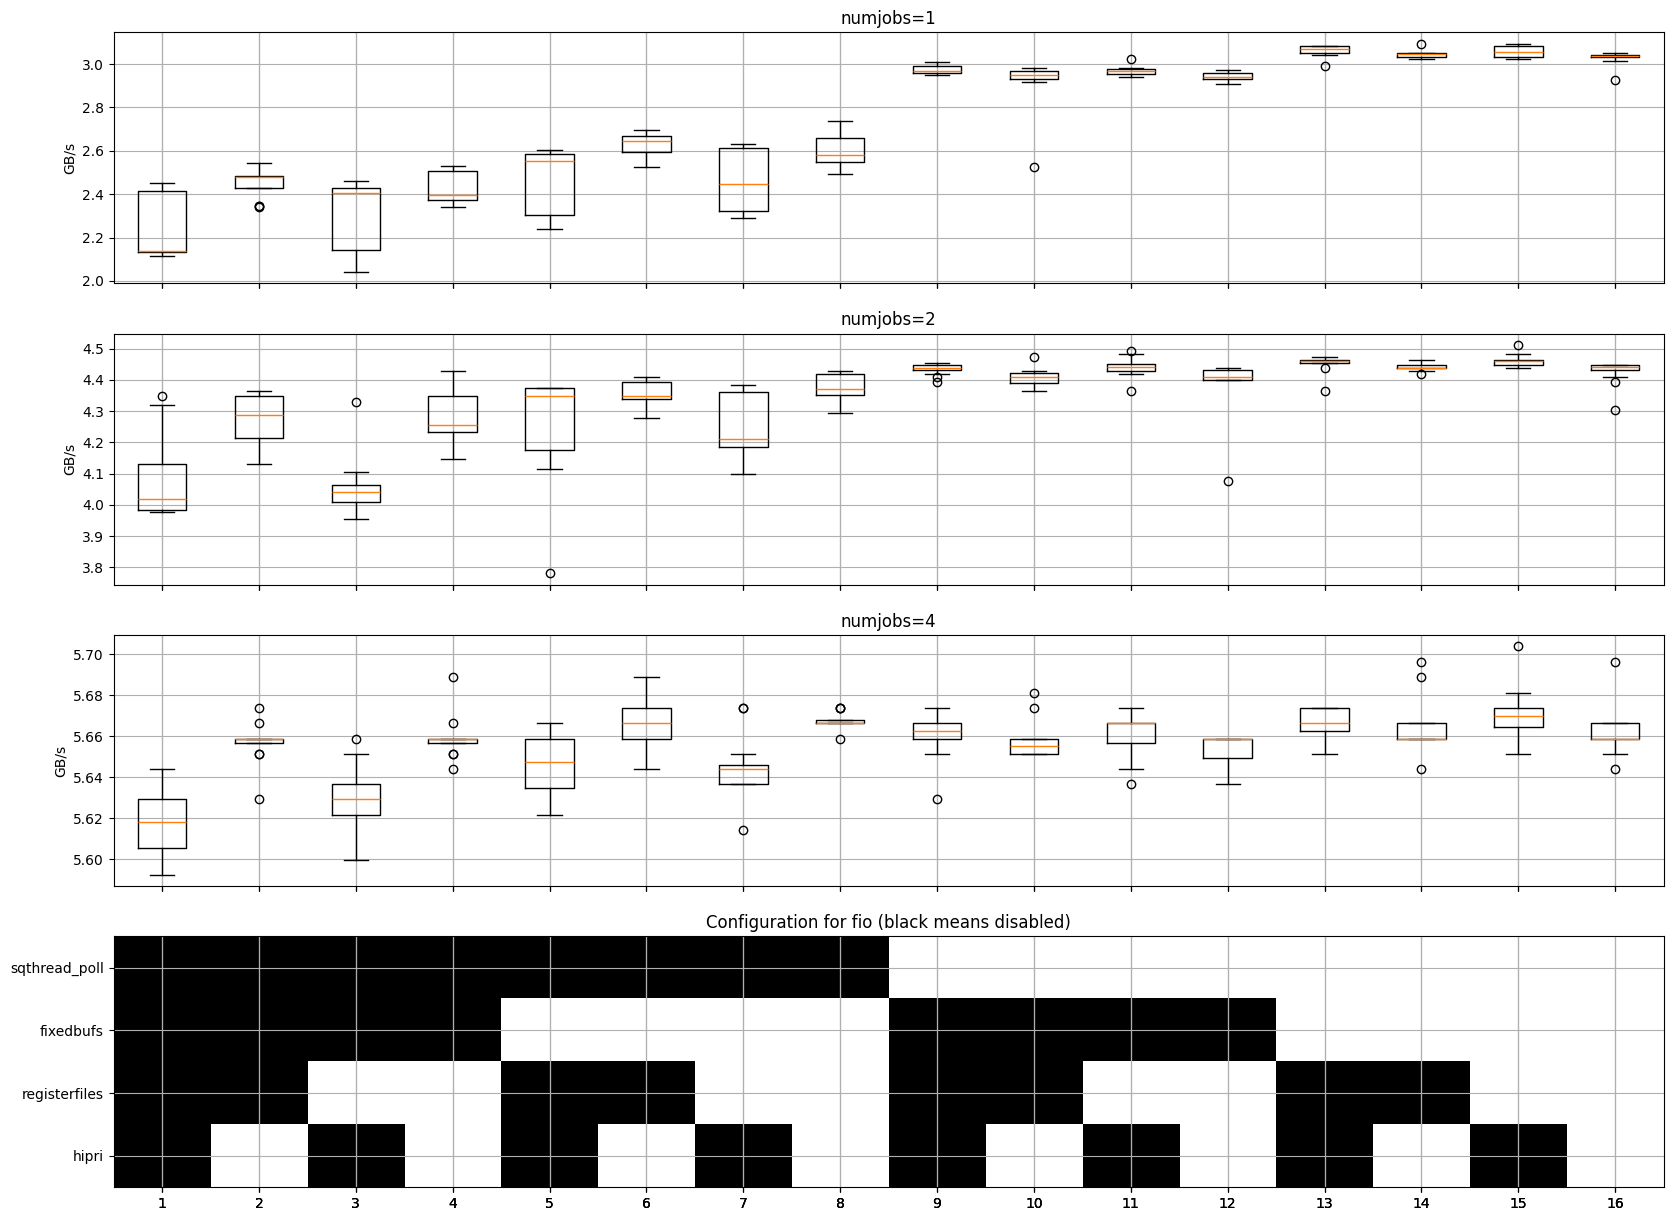

In [434]:
arg_names = ["sqthread_poll", "fixedbufs", "registerfiles", "hipri"]
fio_results_sorted = fio_results.sort_values(["numjobs"] + arg_names)

fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(20, 15))

for numjobs, ax in zip([1, 2, 4], axes):
    query = f"numjobs=={numjobs} & iodepth==32 & blocksize==8"
    ax.set_title(f"{numjobs=}")
    data = fio_results_sorted.query(query).pivot_table(values="gigabytes_per_sec", index=["repeat", "thread"], columns=arg_names)
    ax.boxplot(data, showfliers=True)
    ax.set_ylabel("GB/s")

# Set the y-axis on the bottom 2 subplots to have the same spacing as the first subplot:
ax0_y_range = -np.subtract(*axes[0].get_ylim())
half_range = ax0_y_range / 2
for ax in axes[1:2]:
    mid = np.mean(ax.get_ylim())
    #ax.set_ylim(
    #    (
    #        mid - half_range,
    #        mid + half_range
    #    )
    #)

# Add grid to bottom, which shows which parameter is enabled:
ax = axes[-1]
ax.set_title("Configuration for fio (black means disabled)")
n_xaxis_ticks = len(data.columns)
n_params = len(arg_names)
arr = np.array(data.columns, dtype=",".join(["float32"] * n_params))
arr = arr.view(np.float32).reshape(arr.shape + (-1,))
ax.imshow(-arr.T, cmap="Greys", aspect="auto", extent=(0.5, n_xaxis_ticks + 0.5, n_params, 0))
ax.set_yticks(np.arange(n_params) + 0.5)
ax.set_yticklabels(arg_names);

# Formatting for all subplots:
for ax in axes:
    ax.grid()